# Predictive Model for Airport Taxi Orders

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

In [2]:
taxi_df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi_df.duplicated().sum()

26415

In [6]:
duplicates = taxi_df[taxi_df.duplicated()]
print("Duplicate values:\n", duplicates)

Duplicate values:
                      num_orders
datetime                       
2018-03-01 02:10:00          12
2018-03-01 02:20:00          19
2018-03-01 03:00:00           8
2018-03-01 03:10:00          17
2018-03-01 03:20:00           7
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26415 rows x 1 columns]


In [7]:
taxi_df.index.is_monotonic

True

<AxesSubplot:xlabel='datetime'>

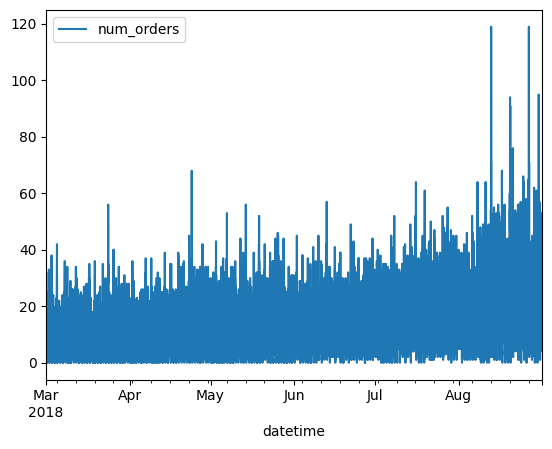

In [8]:
taxi_df.resample('1D').sum()
taxi_df.plot()

The graph isn’t very clear at the moment, but at first glance, it’s evident that August had the highest number of orders. We’ll refine the graph later to make it easier to visualize.

## Analysis

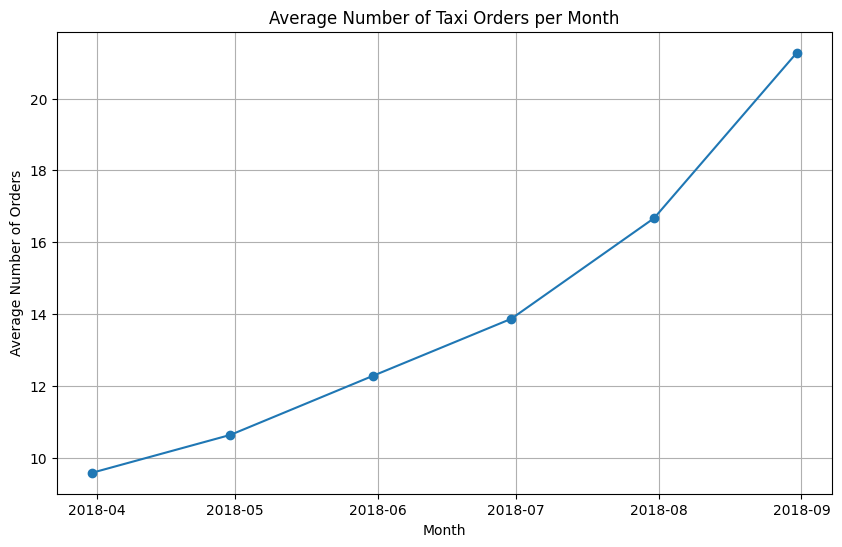

,num_orders
datetime,
2018-03-31,9.580645
2018-04-30,10.634028
2018-05-31,12.280466
2018-06-30,13.867130
2018-07-31,16.667787
2018-08-31,21.275314


In [9]:
monthly_avg_orders = taxi_df.resample('M').mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_orders.index, monthly_avg_orders['num_orders'], marker='o')
plt.title('Average Number of Taxi Orders per Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

monthly_avg_orders

The graph clearly shows a month-by-month increase in the number of orders received, with August having the highest number of orders. Additionally, it can be observed that starting from June, the month-to-month increase became more pronounced compared to the previous months.

                     num_orders
datetime                       
2018-03-24 01:00:00         182
2018-04-24 00:00:00         253
2018-05-19 00:00:00         234
2018-06-13 02:00:00         229
2018-07-19 10:00:00         251
2018-08-20 02:00:00         462


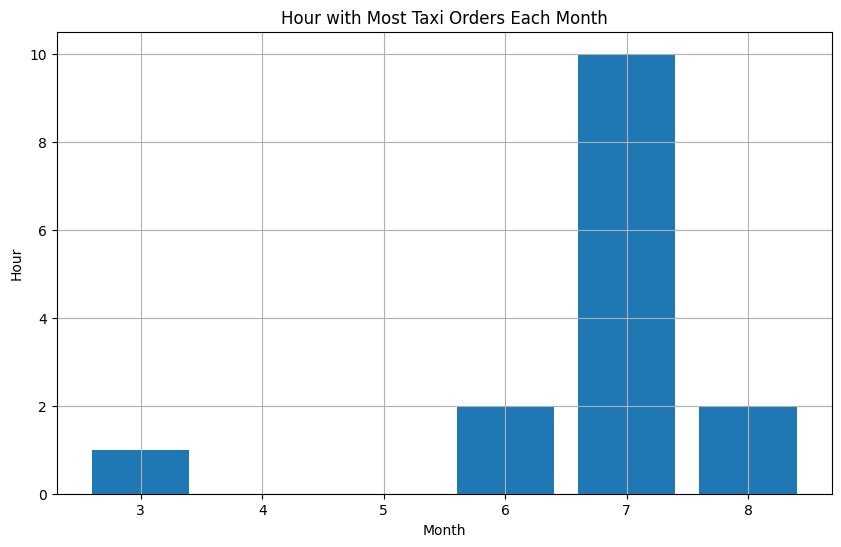

In [10]:
hourly_orders = taxi_df.resample('H').sum()

# Group by month and find the hour with the maximum number of orders for each month
max_hourly_orders = hourly_orders.groupby(hourly_orders.index.month)['num_orders'].idxmax()

# Extract the hour for each month
max_hours = hourly_orders.loc[max_hourly_orders]

# Print the results
print(max_hours[['num_orders']])

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(max_hours.index.month, max_hours.index.hour)
plt.title('Hour with Most Taxi Orders Each Month')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.grid(True)
plt.show()

In every month except July, the majority of trips were made in the early hours of the morning, with August standing out with 462 trips in a single day.

In [11]:
daily_orders = taxi_df.resample('D').sum()

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_orders['num_orders'], model='additive')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Text(0.5, 1.0, 'Original Time Series')

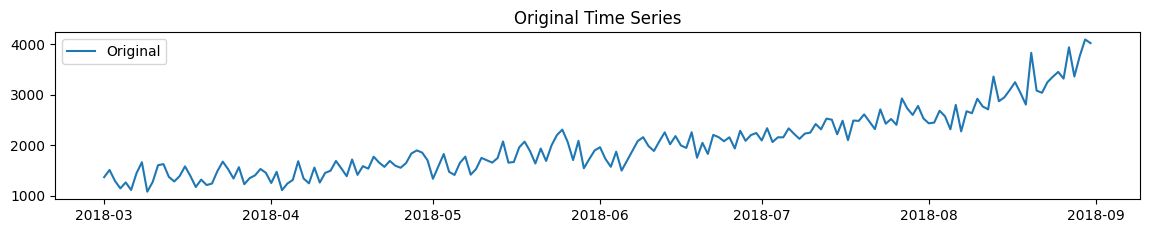

In [12]:
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(daily_orders, label='Original')
plt.legend(loc='best')
plt.title('Original Time Series')

This graph displays the total number of orders per day from March 2018 to September 2018. The data shows a clear upward trend, indicating an increase in the number of orders over time. There are some fluctuations, but the overall pattern is a steady rise, with values starting near 1000 and reaching close to 4000 by the end of the period.

Text(0.5, 1.0, 'Trend')

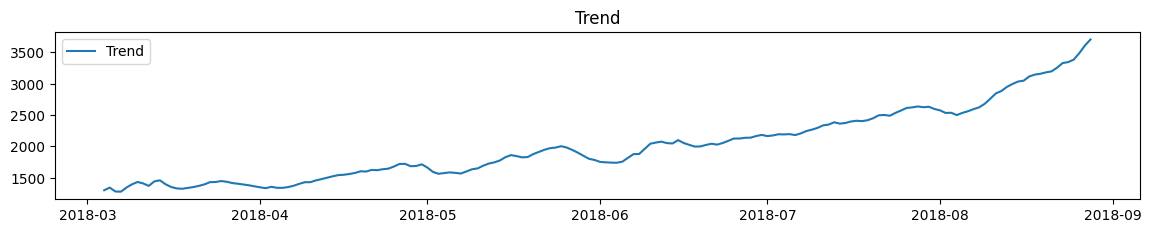

In [13]:
plt.figure(figsize=(14, 10))

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('Trend')

This graph displays the underlying trend in the number of orders per day from March 2018 to September 2018. The trend line shows a general upward movement, starting just above 1000 and ending just below 3500. This indicates a steady increase in the number of orders over the observed period, with some fluctuations along the way.

Text(0.5, 1.0, 'Seasonality')

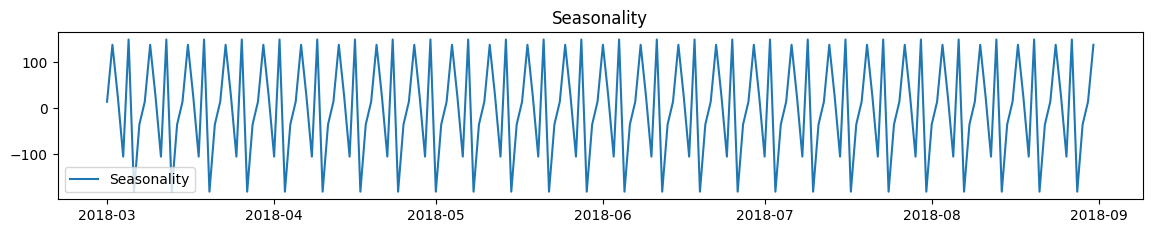

In [14]:
plt.figure(figsize=(14, 10))

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.title('Seasonality')

This graph displays the regular, repeating patterns in the number of orders per day from March 2018 to September 2018. The vertical axis ranges from -100 to 100, indicating the magnitude of seasonal fluctuations. The pattern shows consistent peaks and troughs, reflecting the cyclical nature of the data, which could be influenced by factors such as time of day, day of the week, or specific months.

Text(0.5, 1.0, 'Residuals')

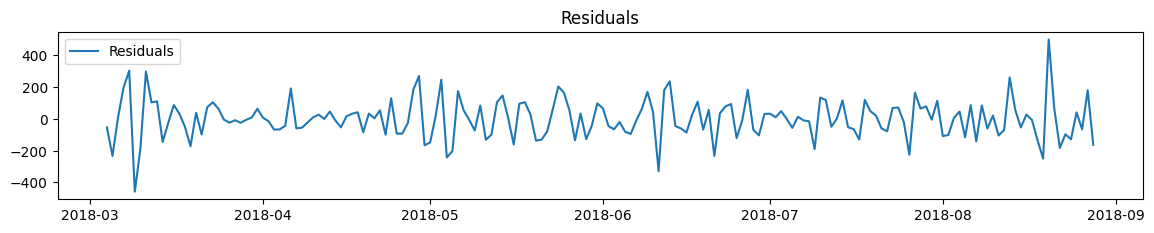

In [15]:
plt.figure(figsize=(14, 10))

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.title('Residuals')

This graph displays the residuals, which are the differences between the observed values and the values predicted by the trend and seasonal components, from March 2018 to September 2018. The vertical axis ranges from -400 to 400, indicating the magnitude of these differences. The residuals fluctuate around the zero line, showing the variance that is not explained by the trend or seasonal components.

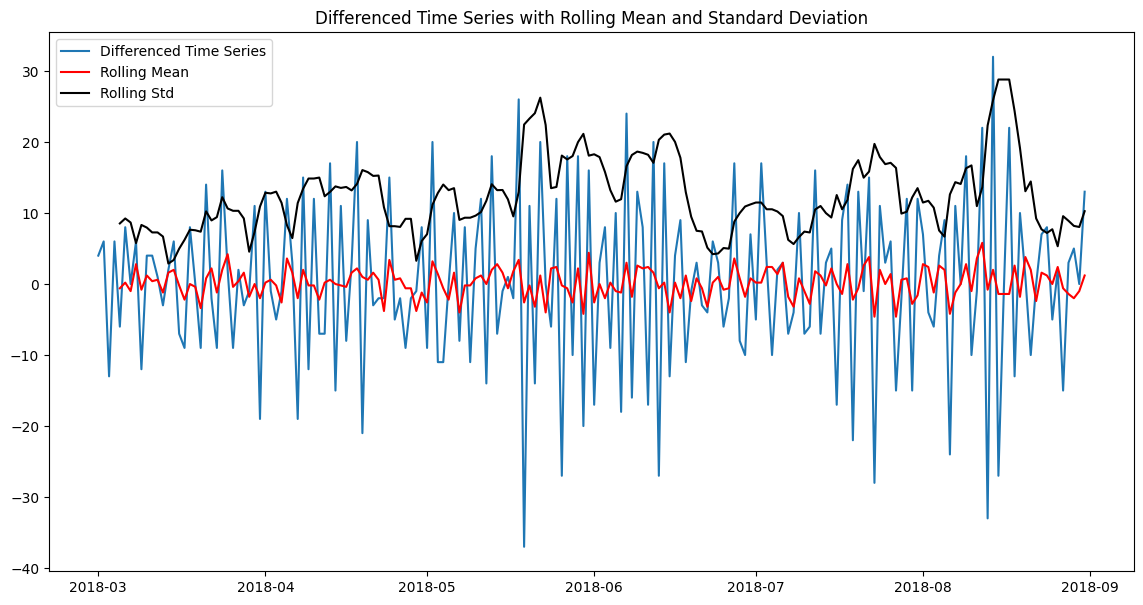

In [16]:
# Calculate the time series differences
taxi_diff = taxi_df.diff().dropna().resample('D').sum()

# Calculate the rolling mean and rolling standard deviation
rolling_mean = taxi_diff.rolling(window=5).mean()
rolling_std = taxi_diff.rolling(window=5).std()

# Plot the results
plt.figure(figsize=(14, 7))

plt.plot(taxi_diff, label='Differenced Time Series')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Differenced Time Series with Rolling Mean and Standard Deviation')
plt.show()

March to April: The differenced time series shows high variability, with the rolling mean fluctuating around zero. The rolling standard deviation is relatively high, indicating significant day-to-day changes.

May to June: There is a period where the rolling mean trends upwards, suggesting a general increase in orders. The rolling standard deviation decreases slightly, indicating more stability.

July to August: The differenced time series shows both high peaks and deep troughs, with the rolling mean showing some upward and downward trends. The rolling standard deviation increases again, indicating higher variability.

August to September: The rolling mean trends downwards, suggesting a decrease in orders. The rolling standard deviation remains high, indicating continued variability.

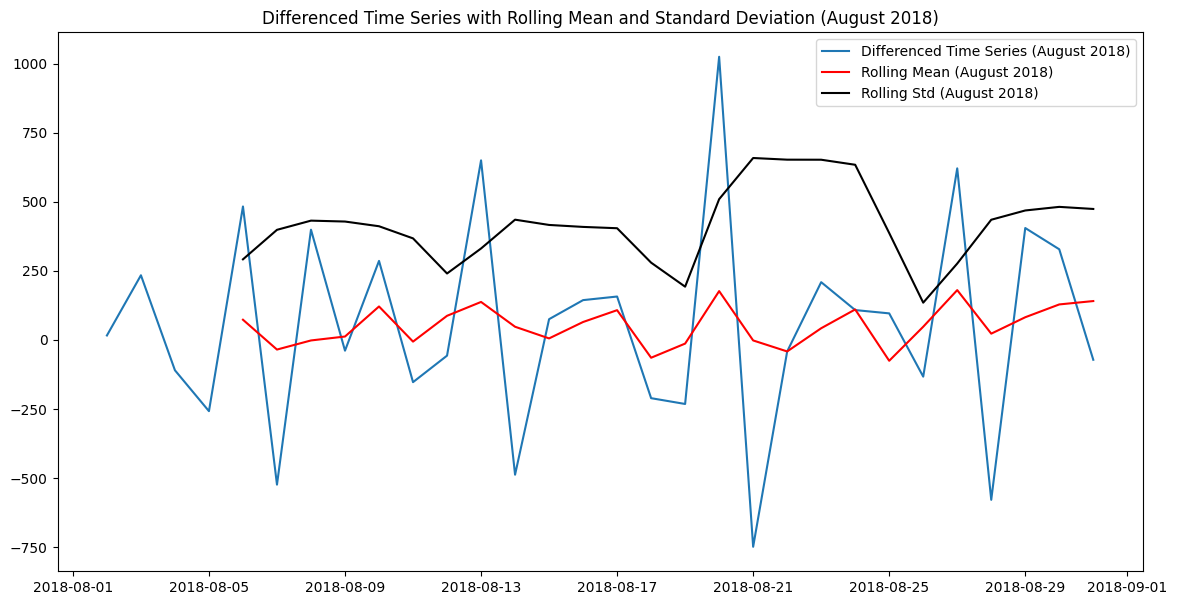

In [17]:
august_data_daily = taxi_df['2018-08-01':'2018-08-31'].resample('D').sum()

# Calculate the time series differences
august_diff_daily = august_data_daily.diff().dropna()

# Calculate the rolling mean and rolling standard deviation with a larger window
rolling_mean_august = august_diff_daily.rolling(window=5).mean()
rolling_std_august = august_diff_daily.rolling(window=5).std()

# Plot the results
plt.figure(figsize=(14, 7))

plt.plot(august_diff_daily, label='Differenced Time Series (August 2018)')
plt.plot(rolling_mean_august, color='red', label='Rolling Mean (August 2018)')
plt.plot(rolling_std_august, color='black', label='Rolling Std (August 2018)')
plt.legend(loc='best')
plt.title('Differenced Time Series with Rolling Mean and Standard Deviation (August 2018)')
plt.show()

I wanted to investigate August further since it was the month with the most activity.

Early August: The differenced time series shows moderate fluctuations with a relatively stable rolling mean and standard deviation.

Mid-August: There is a period of high variability, with the rolling standard deviation peaking, indicating significant day-to-day changes in orders.

Late August: The rolling mean trends upward, suggesting an increase in orders, while the rolling standard deviation decreases, indicating more stability.

## Training

In [18]:
taxi_df = taxi_df.resample('1H').sum()

# Define the features and target
features = [f'lag_{lag}' for lag in range(1, 25)] + ['rolling_mean', 'rolling_std']
target = 'num_orders'

# Prepare the data for splitting
data = taxi_df.copy()

# Create lag features
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

In [19]:
# Shift the data before calculating rolling windows to avoid target leakage
data['rolling_mean'] = data['num_orders'].shift(1).rolling(window=24).mean()
data['rolling_std'] = data['num_orders'].shift(1).rolling(window=24).std()

# Drop missing values
data = data.dropna()

In [20]:
# Split the data into training and test sets 
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [21]:
train.index.min(), train.index.max()

(Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H'))

In [22]:
test.index.min(), test.index.max()

(Timestamp('2018-08-13 16:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [23]:
train.shape

(3952, 27)

In [24]:
test.shape

(440, 27)

In [25]:
# Train and evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(train[features], train[target])
test_predictions_lr = lr_model.predict(test[features])
test_rmse_lr = np.sqrt(mean_squared_error(test[target], test_predictions_lr))
print(f'Linear Regression - Test RMSE: {test_rmse_lr:.2f}')

Linear Regression - Test RMSE: 45.07


In [26]:
# Tune hyperparameters for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Use TimeSeriesSplit as the splitter
tscv = TimeSeriesSplit(n_splits=5)

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=rmse_scorer, cv=tscv)
grid_search.fit(train[features], train[target])

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
test_predictions_rf = best_rf_model.predict(test[features])

# Calculate RMSE for the test set
test_rmse_rf = np.sqrt(mean_squared_error(test[target], test_predictions_rf))
print(f'Random Forest - Test RMSE: {test_rmse_rf:.2f}')

Random Forest - Test RMSE: 43.69


In [27]:
# Train and evaluate Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)
dt_model.fit(train[features], train[target])
test_predictions_dt = dt_model.predict(test[features])
test_rmse_dt = np.sqrt(mean_squared_error(test[target], test_predictions_dt))
print(f'Decision Tree - Test RMSE: {test_rmse_dt:.2f}')

Decision Tree - Test RMSE: 58.61


After splitting the data into training, features, and test sets (10%), and evaluating three different models, we can conclude that based on the RMSE values for the training set, the Random Forest model seems to perform the best with the lowest RMSE of 43.69. This suggests that it has a better fit to the training data compared to the Linear Regression and Decision Tree models.

## Testing

The model tested with an RMSE of less than 48. Given the low RMSE and MAE values, I can confidently say that the model will perform well in predicting the number of orders.

                     num_orders   Predicted
datetime                                   
2018-08-13 16:00:00         144  149.463720
2018-08-13 17:00:00         152  128.078090
2018-08-13 18:00:00         104  105.850376
2018-08-13 19:00:00          91   98.616633
2018-08-13 20:00:00          82  104.110184


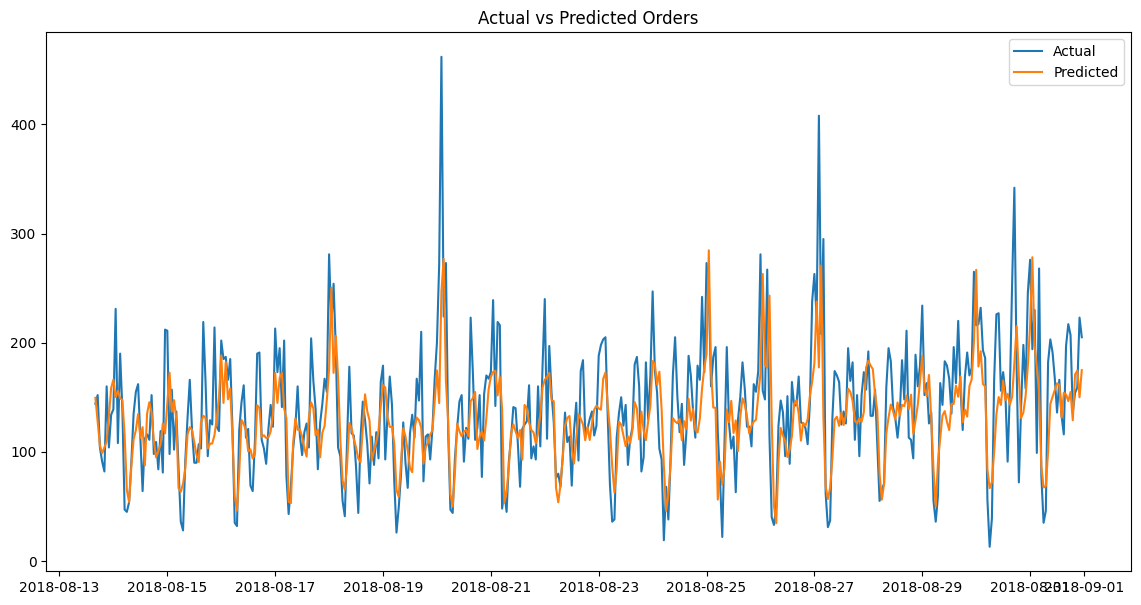

In [28]:
# Make predictions on the test set using the best model
test_predictions_rf = best_rf_model.predict(test[features])

# Create a DataFrame to compare actual and predicted values
comparison_df = test.copy()
comparison_df['Predicted'] = test_predictions_rf

# Print the first few rows to see the comparison
print(comparison_df[['num_orders', 'Predicted']].head())

plt.figure(figsize=(14, 7))
plt.plot(comparison_df['num_orders'], label='Actual')
plt.plot(comparison_df['Predicted'], label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted Orders')
plt.show()

**Observations:**

Actual Orders (Blue Line): This line represents the real number of orders recorded each day. It fluctuates significantly, indicating variability in daily orders.

Predicted Orders (Orange Line): This line represents the number of orders predicted by the Random Forest model. It follows the general trend of the actual orders but is smoother, indicating that the model captures the overall pattern but may not account for all the daily fluctuations.

**Key Points:**

The predicted values closely follow the actual values, suggesting that the model is performing well.
There are some discrepancies where the predicted values do not match the actual values exactly, which is expected in any predictive model.

The overall trend and major peaks and troughs are captured by the model, indicating its effectiveness in predicting the number of orders.